In [1]:
print("""Feedback from Brian:
1) Combine to put all ephys features in one plot -- NOT SURE HOW?

*Use Tree call column when you have a large dataset
*Use NMS for smaller dataset now""")

Feedback from Brian:
1) Combine to put all ephys features in one plot -- NOT SURE HOW?

*Use Tree call column when you have a large dataset
*Use NMS for smaller dataset now


##### Imports 

In [2]:
import pandas as pd
import numpy as np
import csv
import logging
import os
from functions.temp_funcs import read_file, merge_dataframes, drop_cols, drop_nans, filter_date_range, \
filter_df, create_container_col, create_cond_df

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(context = "notebook", style = "ticks", font="verdana") # font_scale = 1.35)

##### Logging Set-up

In [3]:
logging.basicConfig(level=logging.INFO)
LOGGER = logging.getLogger(__name__)

##### Pandas Display Settings

In [4]:
pd.set_option("display.max_colwidth",150) #Expands the number of characters shown in the columns
pd.set_option('display.max_columns', None)

##### Lists/Paths

In [5]:
path = "C:/Users/kumar/Documents/Github/analysis_projects/analysis_scripts/"
csv_path = os.path.join(path, "csv/")
excel_path = os.path.join(path, "excel/")
plot_path = os.path.join(path, "plot/")

In [6]:
path_jem = os.path.join(csv_path, "jem_metadata_wFAILURE.csv")
path_ephys = os.path.join(csv_path, "ephys_mIVSCC_MET.csv")
path_shiny = os.path.join(csv_path, "Mouse_VISp_ctx_shiny.csv")

In [7]:
fields_jem = ["date", "organism_name", "container", "rigOperator", "status", "roi"]
              #"extraction.postPatch", "extraction.endPipetteR"]
fields_ephys = ["name", "vrest", "ri", "sag", "tau",
                "upstroke_downstroke_ratio_long_square", "latency", "f_i_curve_slope"]
fields_shiny = ["patch.date", "cell_name", "sample_id", "cell_specimen_project",
                "subclass_label", "broad_class_label",
                "marker_sum_norm_label", "Norm_Marker_Sum.0.4_label"] #"Tree_call", "topLeaf_label"

In [8]:
drop_nans_list = ["date"]
drop_cols_list = ["sample_id", "patch.date", "status", "name", "cell_specimen_project", "organism_name"]

##### Writing to Excel File

In [9]:
def save_to_excel():
    """"""
    writer = pd.ExcelWriter(excel_path + "mephys_final_home.xlsx")
    rsp_visp_glu.to_excel(writer, "RSP_VISP_Glu", freeze_panes=(1,0))
    rsp_glu.to_excel(writer, "RSP_Glu", freeze_panes=(1,0))
    visp_glu.to_excel(writer, "VISP_Glu", freeze_panes=(1,0))
    merge_all.to_excel(writer, "All", freeze_panes=(1,0))
    merge_sj.to_excel(writer, "Shiny_Jem", freeze_panes=(1,0))
    shiny.to_excel(writer, "Shiny", freeze_panes=(1,0))
    jem.to_excel(writer, "Jem", freeze_panes=(1,0))
    ephys.to_excel(writer, "Ephys", freeze_panes=(1,0))
    writer.save()
    LOGGER.info("All dataframes have been saved to excel file")

##### Main

In [10]:
def main():
    global jem, shiny, ephys, merge_sj, merge_all, merge_all_glu, merge_all_gab, rsp_glu, visp_glu, rsp_visp_glu
    jem = read_file(path_jem, fields_jem) #20843 rows
    ephys = read_file(path_ephys, fields_ephys) #8541 rows
    shiny = read_file(path_shiny, fields_shiny) #10674 rows

    jem = filter_df(jem, "status", "SUCCESS") #13325 rows
    jem = filter_date_range(jem, "date") #6335 rows
    
    shiny = filter_df(shiny, "Norm_Marker_Sum.0.4_label", True) #9101 rows
    shiny = filter_date_range(shiny, "patch.date") #2849 rows

    merge_sj = merge_dataframes(shiny, jem, "sample_id", "container", "inner") #2850 rows (even if how=left)
    merge_all = merge_dataframes(merge_sj, ephys, "cell_name", "name", "inner") #2635 rows

    merge_all = drop_nans(merge_all, drop_nans_list)
    merge_all = drop_cols(merge_all, drop_cols_list)
    merge_all = create_container_col(merge_all, "rigOperator")
    merge_all.set_index("date", inplace=True)
    
    merge_all["region"] = pd.np.where(merge_all.roi.str.contains("RSP"), "RSP", 
                                      pd.np.where(merge_all.roi.str.contains("VISp"), "VISp", 
                                      pd.np.where(merge_all.roi.str.contains("TEa"), "TEa",
                                      pd.np.where(merge_all.roi.str.contains("CTXsp"), "CLA",
                                      pd.np.where(merge_all.roi.str.contains("MO"), "MO",
                                      pd.np.where(merge_all.roi.str.contains("ORB"), "ORB",
                                      pd.np.where(merge_all.roi.str.contains("SSp"), "SSp",
                                      pd.np.where(merge_all.roi.str.contains("HY"), "HY", "Unknown"))))))))
    
    merge_all_glu = create_cond_df(merge_all, "broad_class_label", ["Glutamatergic"])
    merge_all_gab = create_cond_df(merge_all, "broad_class_label", ["GABAergic"])

    rsp_glu = create_cond_df(merge_all_glu, "region", ["RSP"])
    visp_glu = create_cond_df(merge_all_glu, "region", ["VISp"])
    rsp_visp_glu = pd.concat([rsp_glu, visp_glu])
    

In [11]:
if __name__ == "__main__":
    main()
    entry = input("Type y or n to save dataframes to excel file:")
    if entry.lower() == "y":
        save_to_excel()
    elif entry.lower() == "n":
        LOGGER.info("The dataframes did not get saved to excel file.")
    else:
        LOGGER.info("Please print y or n.")

INFO:functions.temp_funcs:Read file in as a pandas dataframe
INFO:functions.temp_funcs:Read file in as a pandas dataframe
INFO:functions.temp_funcs:Read file in as a pandas dataframe
INFO:functions.temp_funcs:Filtered dataframe based on status == SUCCESS
C:\Users\kumar\Documents\GitHub\analysis_projects\analysis_scripts\functions\temp_funcs.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df.sort_values([date_col], inplace=True)
INFO:functions.temp_funcs:Filtered dataframe: 2019-01-01 - 2020-12-31
INFO:functions.temp_funcs:Filtered dataframe based on Norm_Marker_Sum.0.4_label == True
INFO:functions.temp_funcs:Filtered dataframe: 2019-01-01 - 2020-12-31
INFO:functions.temp_funcs:Merged two pandas dataframe into one dataframe
INFO:functions.temp_funcs:Merged two pandas dataframe into one dataframe
INFO:functions.temp

Type y or n to save dataframes to excel file:y


INFO:__main__:All dataframes have been saved to excel file


##### Count Tracker for subclasses

In [12]:
merge_all.reset_index(inplace=True)

In [13]:
start_date = merge_all["date"].str[0:10].min()
end_date = merge_all["date"].str[0:10].max()
print(f"Start date: {start_date} & End Date: {end_date}")

Start date: 2019-01-03 & End Date: 2020-02-03


In [15]:
merge_all.subclass_label.unique()

array(['Vip', 'Sst', 'L6 Car3', 'Pvalb', 'Sst Chodl', 'Sncg', 'L6 CT CTX',
       'Lamp5', 'L5 ET CTX', 'L5 IT CTX', 'L4/5 IT CTX', 'L6 IT CTX',
       'L2/3 IT CTX', 'L5 NP CTX', 'L6b CTX', 'L2 IT RSP-ACA', 'DG',
       'L6 CT SUB', 'L5 IT TPE-ENT', 'L2/3 IT PPP', 'L2 IT ENTm',
       'L5 PPP', 'L3 RSP-ACA', 'SUB', 'L2/3 IT TPE', 'L6 CT L6b ENT',
       'L2/3 IT ENTl'], dtype=object)

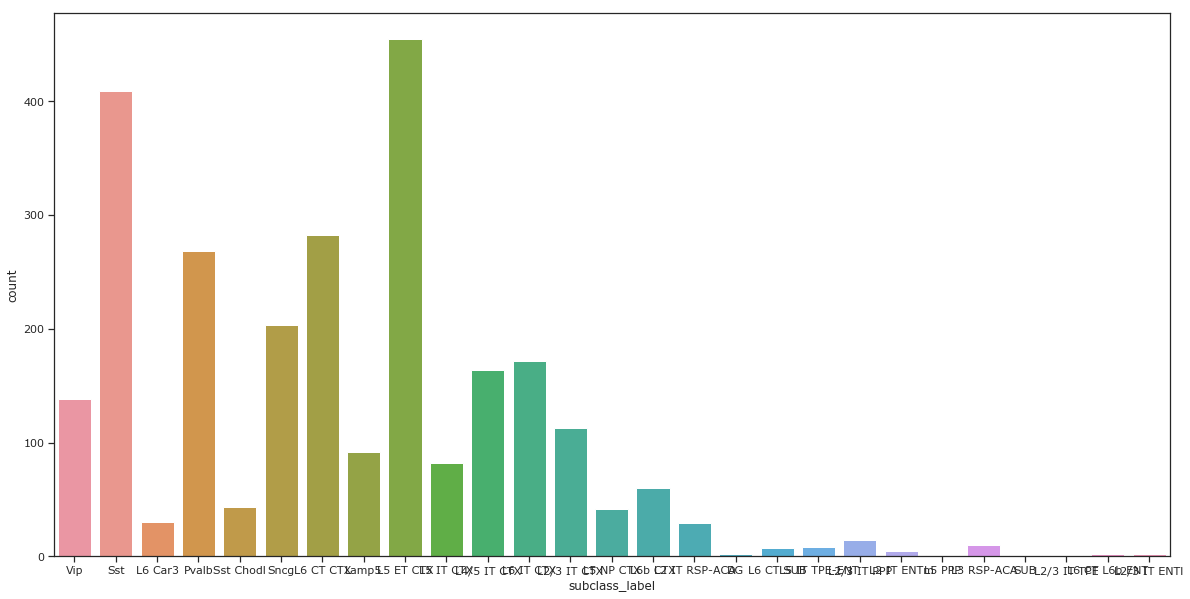

In [16]:
fig_dims = (20, 10)
f, axes = plt.subplots(figsize=fig_dims)

sns.countplot(x="subclass_label", data=merge_all)

##### Misc Info

In [17]:
#merge_all #2787 rows
#merge_all_glu #1583 rows
#merge_all_gab #1204 rows

In [18]:
rsp_visp_glu.reset_index(inplace=True)
rsp_visp_glu.sort_values(["subclass_label"], inplace=True)
rsp_glu.sort_values(["subclass_label"], inplace=True)
visp_glu.sort_values(["subclass_label"], inplace=True)

C:\Users\kumar\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\kumar\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [19]:
#rsp_visp_glu #1424 rows
#Start Date: 1.04.2019 
#End Date: 1.31.2020
#rsp_visp_glu

In [20]:
#rsp_glu.replace({"roi_major": {"RSPd": "RSP", "RSPv": "RSP"}}, inplace=True)
#mo_glu.replace({"roi_major": {"MOp": "MO", "MOs": "MO"}}, inplace=True)

In [21]:
"""
region_dict = {"Overall Mouse Total count": merge_all.name.count(),
               "RSP Total": rsp.name.count(),
               "SSp Total": ssp.name.count(),
               "ORB Total": orb.name.count(),
               "CTXsp Total": ctxsp.name.count(),
               "MO Total": mo.name.count(),
               "VISp Total": visp.name.count()}

glu_dict = {"Glutamatergic Mouse Total count": merge_all_glu.name.count(),
            "RSP": rsp_glu.name.count(),
            "SSp": ssp_glu.name.count(),
            "ORB": orb_glu.name.count(),
            "CTXsp": ctxsp_glu.name.count(),
            "MO": mo_glu.name.count(),
            "VISp": visp_glu.name.count()}

gab_dict = {"GABAergic Mouse Total count": merge_all_gab.name.count(),
            "RSP": rsp_gab.name.count(),
            "SSp": ssp_gab.name.count(),
            "ORB": orb_gab.name.count(),
            "CTXsp": ctxsp_gab.name.count(),
            "MO": mo_gab.name.count(),
            "VISp": visp_gab.name.count()}

for k,v in region_dict.items():
    print(f"{k} : {v}")
    
for k,v in glu_dict.items():
    print(f"{k} : {v}")

for k,v in gab_dict.items():
    print(f"{k} : {v}")
"""

'\nregion_dict = {"Overall Mouse Total count": merge_all.name.count(),\n               "RSP Total": rsp.name.count(),\n               "SSp Total": ssp.name.count(),\n               "ORB Total": orb.name.count(),\n               "CTXsp Total": ctxsp.name.count(),\n               "MO Total": mo.name.count(),\n               "VISp Total": visp.name.count()}\n\nglu_dict = {"Glutamatergic Mouse Total count": merge_all_glu.name.count(),\n            "RSP": rsp_glu.name.count(),\n            "SSp": ssp_glu.name.count(),\n            "ORB": orb_glu.name.count(),\n            "CTXsp": ctxsp_glu.name.count(),\n            "MO": mo_glu.name.count(),\n            "VISp": visp_glu.name.count()}\n\ngab_dict = {"GABAergic Mouse Total count": merge_all_gab.name.count(),\n            "RSP": rsp_gab.name.count(),\n            "SSp": ssp_gab.name.count(),\n            "ORB": orb_gab.name.count(),\n            "CTXsp": ctxsp_gab.name.count(),\n            "MO": mo_gab.name.count(),\n            "VISp": vi

##### Plot Functions

In [22]:
b_colors={"RSP": "#a1d99b", "VISp": "#9ecae1"}
s_colors={"RSP": "#41ab5d", "VISp": "#4292c6"}

In [23]:
region_list = ["RSP", "VISp"]
sub_list = ["L2 IT RSP-ACA", "L5 ET CTX", "L5 NP CTX"]

In [24]:
rsub_list = list()
rless_list = list()
for n in rsp_glu.subclass_label.unique():
    ex = rsp_glu[rsp_glu["subclass_label"] == n]
    value = ex["vrest"].count() > 5
    if value == True:
        rsub_list.append(n)
    else:
        rless_list.append(n)

vsub_list = list()
vless_list = list()
for n in visp_glu.subclass_label.unique():
    ex = visp_glu[visp_glu["subclass_label"] == n]
    value = ex["vrest"].count() > 5
    if value == True:
        vsub_list.append(n)
    else:
        vless_list.append(n)
        
#print(f"This list has greater than 5 datapoints: {rsub_list}")
#print(f"This list has less than 5 datapoints: {rless_list}")
#print(f"This list has greater than 5 datapoints: {vsub_list}")
#print(f"This list has less than 5 datapoints: {vless_list}")

sub_list = list(set(rsub_list) & set(vsub_list))
print(f"Combined subclass list(greater than 5 datapoints): {sub_list}")

Combined subclass list(greater than 5 datapoints): ['L2 IT RSP-ACA', 'L5 NP CTX', 'L5 ET CTX']


In [25]:
def box_plt(col_x, jpg_title, plt_title, xlim_min, xlim_max, df=rsp_visp_glu):
    """Creates a box plot using seaborn and compares the ephys features between
    two mouse regions while displaying the t-types.
    Args:
        col_y(string): y-axis column
        jpg_title(string): title of the jpeg file
        plt_tile(string): title of the plot
        df: a pandas dataframe
    Returns: None
    """
    fig_dims = (8, 4)
    f, axes = plt.subplots(figsize=fig_dims)

    ax = sns.boxplot(x=col_x, y="subclass_label", hue="region", data=df[df[col_x] < xlim_max],
                     order = sub_list, hue_order = region_list,
                     palette=b_colors, saturation=1, width=0.8, linewidth=1.3, showfliers=False)

    ax = sns.stripplot(x=col_x, y="subclass_label", hue="region", data=df[df[col_x] < xlim_max],
                       order = sub_list, hue_order = region_list,
                       jitter=False, size=4.5, palette=s_colors, dodge=True, linewidth=0.5)
    
    #sns.despine(trim=True)
    handles, labels = ax.get_legend_handles_labels()
    l = plt.legend(handles[0:2], labels[0:2], title="Region")
    
    #ax.legend_.remove()
    ax.set(xlabel=plt_title, ylabel="Subclass")
    ax.set(xlim=(xlim_min, xlim_max))
    plt.savefig(plot_path + "box_plt_" + jpg_title + ".jpeg", bbox_inches="tight")

##### Plot Outputs

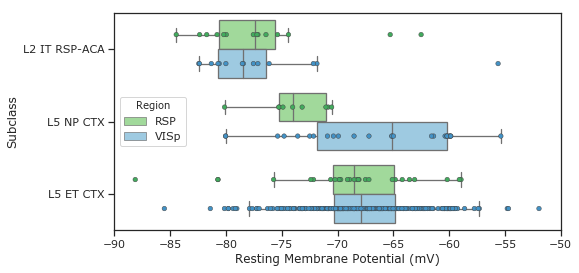

In [26]:
box_plt("vrest", "rmp", "Resting Membrane Potential (mV)", -90, -50)
#box_plt("ri", "rin", "Input Resistance (MOhms)", 0, 500)
#box_plt("sag", "sag", "Sag", 0, 0.35)
#box_plt("tau", "tau", "Time Constant", 0, 35)
#box_plt("upstroke_downstroke_ratio_long_square", "udr", "Upstroke/Downstroke", 0, 6)
#box_plt("latency", "lat", "Latency", 0, 0.10)
#box_plt("f_i_curve_slope", "fis", "F-I Curve", 0, 0.60)

[Text(0,0.5,'Subclass'), Text(0.5,0,'Sag')]

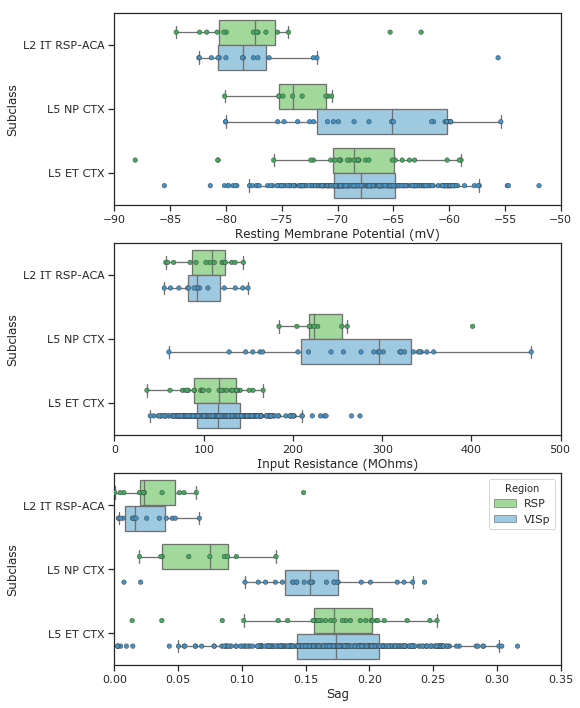

In [27]:
fig_dims = (8, 12)
f, axes = plt.subplots(nrows=3, ncols=1, figsize=fig_dims)


ax = sns.boxplot(y="subclass_label", x="vrest", hue="region", data=rsp_visp_glu[rsp_visp_glu["vrest"] < -50],
                 order = sub_list, hue_order = region_list,
                 palette=b_colors, saturation=1, width=0.8, linewidth=1.3, showfliers=False, ax=axes[0])


ax = sns.stripplot(y="subclass_label", x="vrest", hue="region", data=rsp_visp_glu[rsp_visp_glu["vrest"] < -50],
                   order = sub_list, hue_order = region_list,
                   jitter=False, size=4.5, palette=s_colors, dodge=True, linewidth=0.5, ax=axes[0])


ax1 = sns.boxplot(y="subclass_label", x="ri", hue="region", data=rsp_visp_glu[rsp_visp_glu["ri"] < 500],
                  order = sub_list, hue_order = region_list,
                  palette=b_colors, saturation=1, width=0.8, linewidth=1.3, showfliers=False, ax=axes[1])

ax1 = sns.stripplot(y="subclass_label", x="ri", hue="region", data=rsp_visp_glu[rsp_visp_glu["ri"] < 500],
                    order = sub_list, hue_order = region_list,
                    jitter=False, size=4.5, palette=s_colors, dodge=True, linewidth=0.5, ax=axes[1])


ax2 = sns.boxplot(y="subclass_label", x="sag", hue="region", data=rsp_visp_glu[rsp_visp_glu["sag"] < 0.35],
                  order = sub_list, hue_order = region_list,
                  palette=b_colors, saturation=1, width=0.8, linewidth=1.3, showfliers=False, ax=axes[2])

ax2 = sns.stripplot(y="subclass_label", x="sag", hue="region", data=rsp_visp_glu[rsp_visp_glu["sag"] < 0.35],
                    order = sub_list, hue_order = region_list,
                    jitter=False, size=4.5, palette=s_colors, dodge=True, linewidth=0.5, ax=axes[2])

handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2], title="Region")

ax.legend_.remove()
ax1.legend_.remove()
#ax2.legend_.remove()

ax.set(xlim=(-90, -50))
ax1.set(xlim=(0, 500))
ax2.set(xlim=(0, 0.35))
ax.set(ylabel="Subclass", xlabel="Resting Membrane Potential (mV)")
ax1.set(ylabel="Subclass", xlabel="Input Resistance (MOhms)")
ax2.set(ylabel="Subclass", xlabel="Sag")

##### HeatMap

In [149]:
for n in rsp_glu.subclass_label.unique():
    print(n)

L2 IT RSP-ACA
L2/3 IT CTX
L3 RSP-ACA
L4/5 IT CTX
L5 ET CTX
L5 IT CTX
L5 NP CTX
L6 CT CTX
L6 IT CTX
L6b CTX


In [167]:
for n in rsp_glu.subclass_label.unique():
    num = 1
    ("ex_", num) = rsp_glu[rsp_glu["subclass_label"] == n]
    num += 1

SyntaxError: can't assign to literal (<ipython-input-167-081768f962a0>, line 3)

In [166]:
r

date  \
78  2020-01-27 13:59:45 -0800   
79  2020-01-09 13:07:08 -0800   
80  2020-01-31 13:19:38 -0800   

                                                  cell_name subclass_label  \
78  Vipr2-IRES2-Cre;Slc32a1-IRES2-FlpO;Ai65-508158.02.02.01        L6b CTX   
79                    Slc32a1-IRES-Cre;Ai14-504559.10.01.02        L6b CTX   
80                        Slc17a8-iCre;Ai14-508389.08.01.05        L6b CTX   

   broad_class_label  marker_sum_norm_label  Norm_Marker_Sum.0.4_label  \
78     Glutamatergic               0.883636                       True   
79     Glutamatergic               0.733493                       True   
80     Glutamatergic               0.759992                       True   

              container rigOperator     roi      vrest          ri       sag  \
78  P8S4_200127_356_A01    lindsayn   RSPd5 -60.492583  265.906245  0.172725   
79  P8S4_200109_354_A01    lindsayn   RSPv5 -60.436754  357.499987  0.246145   
80  PFS4_200131_706_A01    jessicat  RSPv6a -62.620595  425.213069  0.149847   

          tau  upstroke_downstroke_ratio_long_square  latency  \
78  23.230423                               2.795705  0.50162   
79  43.943904                               4.015998  0.03550   
80  29.303652                               5.017037  0.03002   

    f_i_curve_slope patch_container_label region  
78         0.008352                    P8    RSP  
79         0.318548                    P8    RSP  
80        -0.005113                    PF    RSP

In [158]:
ex_1 = ex_1[["subclass_label", "region", "vrest", "ri", "sag", "tau"]]
ex_1 = ex_1[["subclass_label", "region", "vrest", "ri", "sag", "tau"]]
ex_1 = ex_1[["subclass_label", "region", "vrest", "ri", "sag", "tau"]]
ex_1 = ex_1[["subclass_label", "region", "vrest", "ri", "sag", "tau"]]
ex_1 = ex_1[["subclass_label", "region", "vrest", "ri", "sag", "tau"]]
ex_1 = ex_1[["subclass_label", "region", "vrest", "ri", "sag", "tau"]]
ex_1 = ex_1[["subclass_label", "region", "vrest", "ri", "sag", "tau"]]
ex_1 = ex_1[["subclass_label", "region", "vrest", "ri", "sag", "tau"]]
ex_1 = ex_1[["subclass_label", "region", "vrest", "ri", "sag", "tau"]]

In [159]:
ex_1 = ex_1.groupby(["subclass_label", "region"]).mean().reset_index()
ex_1 = ex_1.groupby(["subclass_label", "region"]).mean().reset_index()
ex_1 = ex_1.groupby(["subclass_label", "region"]).mean().reset_index()
ex_1 = ex_1.groupby(["subclass_label", "region"]).mean().reset_index()

subclass_label region      vrest          ri       sag        tau
0  L2 IT RSP-ACA    RSP -76.811338  104.348811  0.035903  10.586263

In [ ]:
"""Or, since you're mostly interested in whether there's a change you might imagine turning it into a heatmap,
where columns are t-types, rows are features and color indicates % change from VISp, for example.
"""
heatmap1_data = pd.pivot_table(heatmap_df, values='%change from VISp', 
                     index=["ephys_features"], 
                     columns="subclass_label")
#sns.heatmap(data=rsp_glu, vmin=0, vmax=1, linewidths=.5)

In [33]:
rsp_glu.reset_index(inplace=True)

In [114]:
rl2 = rsp_glu[rsp_glu["subclass_label"] == "L2 IT RSP-ACA"]
r = rl2["vrest"].mean()

vl2 = visp_glu[visp_glu["subclass_label"] == "L2 IT RSP-ACA"]
v = vl2["vrest"].mean()
#print(v) #old

((r - v) / v) * 100 #new - old/old 

0.04976375047574562

In [75]:
rl2 = rsp_glu[rsp_glu["subclass_label"] == "L2 IT RSP-ACA"]

for n in rsp_glu.subclass_label.unique():
    print(n)

L2 IT RSP-ACA
L2/3 IT CTX
L3 RSP-ACA
L4/5 IT CTX
L5 ET CTX
L5 IT CTX
L5 NP CTX
L6 CT CTX
L6 IT CTX
L6b CTX


In [ ]:
rsub_list = list()
rless_list = list()
for n in rsp_glu.subclass_label.unique():
    ex = rsp_glu[rsp_glu["subclass_label"] == n]
    value = ex["vrest"].count() > 5
    if value == True:
        rsub_list.append(n)
    else:
        rless_list.append(n)

In [133]:
rv_df = rsp_visp_glu[["subclass_label", "region", "vrest", "ri", "sag", "tau"]]
rv_piv = rv_df.pivot_table(index=["subclass_label", "region"])
rv_piv

ri       sag        tau      vrest
subclass_label region                                            
DG             VISp    172.453117  0.025190  15.764848 -71.160976
L2 IT ENTm     VISp     98.531306  0.101298  20.938055 -68.620692
L2 IT RSP-ACA  RSP     104.348811  0.035903  10.586263 -76.811338
               VISp     98.861731  0.024403  12.694613 -76.773133
L2/3 IT CTX    RSP      57.729140  0.014439   9.543382 -79.119185
               VISp     67.836134  0.023004  11.676442 -77.377667
L2/3 IT PPP    VISp    134.022846  0.041424  15.779421 -75.377449
L3 RSP-ACA     RSP      86.825591  0.289668  13.088296 -65.180289
               VISp     75.374946  0.231917   8.989039 -66.775607
L4/5 IT CTX    RSP     177.957054  0.101669  43.732152 -59.979497
               VISp    162.471682  0.064352  19.944293 -70.795548
L5 ET CTX      RSP     111.394068  0.166532  15.468225 -69.061524
               VISp    118.302890  0.172716  17.279266 -67.587740
L5 IT CTX      RSP     217.835734  0.063916  28.400857 -67.201502
               VISp    209.809391  0.095233  24.488164 -71.368605
L5 IT TPE-ENT  VISp    143.281147  0.091536  25.213113 -73.458145
L5 NP CTX      RSP     243.984663  0.069398  18.792059 -73.900963
               VISp    270.316173  0.153057  22.180426 -66.517502
L5 PPP         VISp     83.499983  0.057149   9.341747 -74.300412
L6 CT CTX      RSP     102.999970  0.098378   9.024144 -72.319739
               VISp    173.522547  0.129680  15.924181 -70.724212
L6 CT SUB      VISp    126.156251  0.064596  14.568575 -73.189046
L6 Car3        VISp    131.778096  0.047868  16.507518 -74.390368
L6 IT CTX      RSP     135.484431  0.038903  16.311519 -66.040516
               VISp    147.771758  0.051016  17.049474 -73.203375
L6b CTX        RSP     349.539767  0.189573  32.159326 -61.183310
               VISp    207.526891  0.056418  19.564715 -68.607158
SUB            VISp    134.437442  0.162936  14.446945 -71.751733

In [126]:
r_df = rsp_glu[["subclass_label", "region", "vrest", "ri", "sag", "tau"]]
r_piv = r_df.pivot_table(index=["subclass_label", "region"])
r_piv

ri       sag        tau      vrest
subclass_label region                                            
L2 IT RSP-ACA  RSP     104.348811  0.035903  10.586263 -76.811338
L2/3 IT CTX    RSP      57.729140  0.014439   9.543382 -79.119185
L3 RSP-ACA     RSP      86.825591  0.289668  13.088296 -65.180289
L4/5 IT CTX    RSP     177.957054  0.101669  43.732152 -59.979497
L5 ET CTX      RSP     111.394068  0.166532  15.468225 -69.061524
L5 IT CTX      RSP     217.835734  0.063916  28.400857 -67.201502
L5 NP CTX      RSP     243.984663  0.069398  18.792059 -73.900963
L6 CT CTX      RSP     102.999970  0.098378   9.024144 -72.319739
L6 IT CTX      RSP     135.484431  0.038903  16.311519 -66.040516
L6b CTX        RSP     349.539767  0.189573  32.159326 -61.183310

In [135]:
r_piv.melt(id_vars=["subclass_label", "region"], value_vars=["vrest", "ri", "sag", "tau"],
           var_name="ephys_features", value_name="ephys_features_values")

C:\Users\kumar\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:979: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_nested_tuple(tup)


subclass_label  region ephys_features  ephys_features_values
0              NaN     NaN          vrest             -76.811338
1              NaN     NaN          vrest             -79.119185
2              NaN     NaN          vrest             -65.180289
3              NaN     NaN          vrest             -59.979497
4              NaN     NaN          vrest             -69.061524
5              NaN     NaN          vrest             -67.201502
6              NaN     NaN          vrest             -73.900963
7              NaN     NaN          vrest             -72.319739
8              NaN     NaN          vrest             -66.040516
9              NaN     NaN          vrest             -61.183310
10             NaN     NaN             ri             104.348811
11             NaN     NaN             ri              57.729140
12             NaN     NaN             ri              86.825591
13             NaN     NaN             ri             177.957054
14             NaN     NaN             ri             111.394068
15             NaN     NaN             ri             217.835734
16             NaN     NaN             ri             243.984663
17             NaN     NaN             ri             102.999970
18             NaN     NaN             ri             135.484431
19             NaN     NaN             ri             349.539767
20             NaN     NaN            sag               0.035903
21             NaN     NaN            sag               0.014439
22             NaN     NaN            sag               0.289668
23             NaN     NaN            sag               0.101669
24             NaN     NaN            sag               0.166532
25             NaN     NaN            sag               0.063916
26             NaN     NaN            sag               0.069398
27             NaN     NaN            sag               0.098378
28             NaN     NaN            sag               0.038903
29             NaN     NaN            sag               0.189573
30             NaN     NaN            tau              10.586263
31             NaN     NaN            tau               9.543382
32             NaN     NaN            tau              13.088296
33             NaN     NaN            tau              43.732152
34             NaN     NaN            tau              15.468225
35             NaN     NaN            tau              28.400857
36             NaN     NaN            tau              18.792059
37             NaN     NaN            tau               9.024144
38             NaN     NaN            tau              16.311519
39             NaN     NaN            tau              32.159326

In [90]:
v_df = visp_glu[["subclass_label", "region", "vrest", "ri", "sag", "tau"]]
v_piv = v_df.pivot_table(index=["subclass_label", "region"])
v_piv

ri       sag        tau      vrest
subclass_label region                                            
DG             VISp    172.453117  0.025190  15.764848 -71.160976
L2 IT ENTm     VISp     98.531306  0.101298  20.938055 -68.620692
L2 IT RSP-ACA  VISp     98.861731  0.024403  12.694613 -76.773133
L2/3 IT CTX    VISp     67.836134  0.023004  11.676442 -77.377667
L2/3 IT PPP    VISp    134.022846  0.041424  15.779421 -75.377449
L3 RSP-ACA     VISp     75.374946  0.231917   8.989039 -66.775607
L4/5 IT CTX    VISp    162.471682  0.064352  19.944293 -70.795548
L5 ET CTX      VISp    118.302890  0.172716  17.279266 -67.587740
L5 IT CTX      VISp    209.809391  0.095233  24.488164 -71.368605
L5 IT TPE-ENT  VISp    143.281147  0.091536  25.213113 -73.458145
L5 NP CTX      VISp    270.316173  0.153057  22.180426 -66.517502
L5 PPP         VISp     83.499983  0.057149   9.341747 -74.300412
L6 CT CTX      VISp    173.522547  0.129680  15.924181 -70.724212
L6 CT SUB      VISp    126.156251  0.064596  14.568575 -73.189046
L6 Car3        VISp    131.778096  0.047868  16.507518 -74.390368
L6 IT CTX      VISp    147.771758  0.051016  17.049474 -73.203375
L6b CTX        VISp    207.526891  0.056418  19.564715 -68.607158
SUB            VISp    134.437442  0.162936  14.446945 -71.751733

In [93]:
r_piv["ri", "sag", "tau", "vrest"] - v_piv["ri", "sag", "tau", "vrest"]

KeyError: ('ri', 'sag', 'tau', 'vrest')

In [42]:
h_df.melt(id_vars=["subclass_label", "region"], value_vars=["vrest", "ri"],
          var_name="ephys_features", value_name="ephys_features_values")

subclass_label region ephys_features  ephys_features_values
0                DG   VISp          vrest             -79.262287
1                DG   VISp          vrest             -63.059664
2        L2 IT ENTm   VISp          vrest                    NaN
3        L2 IT ENTm   VISp          vrest             -68.620692
4     L2 IT RSP-ACA   VISp          vrest             -82.429642
5     L2 IT RSP-ACA   VISp          vrest                    NaN
6     L2 IT RSP-ACA   VISp          vrest             -71.845912
7     L2 IT RSP-ACA    RSP          vrest             -75.377716
8     L2 IT RSP-ACA    RSP          vrest             -74.397582
9     L2 IT RSP-ACA   VISp          vrest             -80.601778
10    L2 IT RSP-ACA    RSP          vrest             -77.543895
11    L2 IT RSP-ACA   VISp          vrest             -80.002926
12    L2 IT RSP-ACA   VISp          vrest             -80.709535
13    L2 IT RSP-ACA   VISp          vrest             -55.613782
14    L2 IT RSP-ACA   VISp          vrest             -82.371861
15    L2 IT RSP-ACA    RSP          vrest             -79.968904
16    L2 IT RSP-ACA    RSP          vrest             -77.129958
17    L2 IT RSP-ACA   VISp          vrest             -81.308453
18    L2 IT RSP-ACA   VISp          vrest             -76.132541
19    L2 IT RSP-ACA    RSP          vrest             -62.511124
20    L2 IT RSP-ACA    RSP          vrest             -84.453903
21    L2 IT RSP-ACA    RSP          vrest             -80.793434
22    L2 IT RSP-ACA    RSP          vrest             -77.218697
23    L2 IT RSP-ACA    RSP          vrest             -82.354325
24    L2 IT RSP-ACA    RSP          vrest             -80.194367
25    L2 IT RSP-ACA   VISp          vrest             -77.537195
26    L2 IT RSP-ACA    RSP          vrest             -81.721021
27    L2 IT RSP-ACA   VISp          vrest             -78.438789
28    L2 IT RSP-ACA    RSP          vrest             -76.411683
29    L2 IT RSP-ACA   VISp          vrest             -72.165686
...             ...    ...            ...                    ...
2646        L6b CTX   VISp             ri             105.687559
2647        L6b CTX   VISp             ri             316.124976
2648        L6b CTX   VISp             ri             168.343768
2649        L6b CTX   VISp             ri             204.312518
2650        L6b CTX   VISp             ri             214.898944
2651        L6b CTX   VISp             ri             416.531265
2652        L6b CTX   VISp             ri             175.750047
2653        L6b CTX   VISp             ri             271.843672
2654        L6b CTX   VISp             ri             210.542291
2655        L6b CTX   VISp             ri             291.687429
2656        L6b CTX   VISp             ri             156.187445
2657        L6b CTX    RSP             ri             425.213069
2658        L6b CTX   VISp             ri             244.406238
2659        L6b CTX   VISp             ri             266.312480
2660        L6b CTX   VISp             ri             314.812541
2661        L6b CTX    RSP             ri             265.906245
2662        L6b CTX   VISp             ri             271.173209
2663        L6b CTX   VISp             ri                    NaN
2664        L6b CTX   VISp             ri             266.125083
2665        L6b CTX   VISp             ri             160.218775
2666        L6b CTX   VISp             ri             319.151819
2667        L6b CTX   VISp             ri             246.499971
2668        L6b CTX   VISp             ri             158.134118
2669        L6b CTX   VISp             ri             234.843642
2670        L6b CTX   VISp             ri              90.343818
2671        L6b CTX   VISp             ri             137.843758
2672        L6b CTX   VISp             ri             210.125014
2673        L6b CTX   VISp             ri             198.906213
2674        L6b CTX   VISp             ri                    NaN
2675            SUB   VISp             r